CAPSTONE PROJECT 2
PRE_SCRIBE: University Retention Guardian

by Irina Kim
Mentor: Joe Xiao

In [10]:
!pip install xgboost
!pip install ucimlrepo

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from ucimlrepo import fetch_ucirepo 


# 1. Force the separator to be a semicolon
df = pd.read_csv(url, sep=',')

# 2. Normalize column names (fix case and hidden spaces)
df.columns = [c.strip().capitalize() for c in df.columns]

# 3. List columns to confirm 'Target' exists
print("Available columns:", df.columns.tolist())

# Now try to access it
if 'Target' in df.columns:
    print("\nSuccess! First 5 rows of Target:")
    print(df['Target'].head())
else:
    print("\n'Target' still not found. Please check the column list above.")

# Now try to access it
if 'target' in df.columns:
    print("\nSuccess! First 5 rows of Target:")
    print(df['target'].head())
else:
    print("\n'target' still not found. Please check the column list above.")

#target_data = df.iloc[:, -1]
#print(target_data.value_counts())

Available columns: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'Gdp', 'Tar

Value Counts for Target:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

Percentage Distribution:
Target
Graduate    49.932188
Dropout     32.120253
Enrolled    17.947559
Name: proportion, dtype: float64


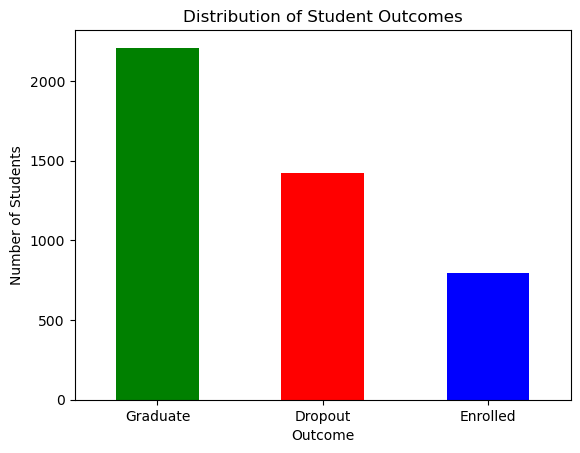

0     Dropout
1    Graduate
2     Dropout
3    Graduate
4    Graduate
Name: Target, dtype: object
Cleaned Dataset for Early Warning: (4424, 31)


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from ucimlrepo import fetch_ucirepo 


# 1. Load Dataset
url = "https://archive.ics.uci.edu/static/public/697/data.csv"
df = pd.read_csv(url, sep=',')

# Fetch dataset 
#df = fetch_ucirepo(id=697)

#print(df.columns)
#print(df.head())
df.columns = df.columns.str.strip()
# 3. Check the unique values and their counts
target_counts = df['Target'].value_counts()
print("Value Counts for Target:")
print(target_counts)

# 4. Calculate percentages
target_pct = df['Target'].value_counts(normalize=True) * 100
print("\nPercentage Distribution:")
print(target_pct)

# 5. Optional: Visualize the distribution
target_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Student Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Number of Students')
plt.xticks(rotation=0)
plt.show()

print(df['Target'].head())

# 2. Target Transformation (Binary)
# 1 = Dropout (The class we want to catch), 0 = Retained (Enrolled or Graduate)
df['Target'] = df['Target'].map({'Dropout': 1, 'Graduate': 0, 'Enrolled': 0})

# 3. Early Warning Feature Filtering
# Removing 2nd semester features to simulate a "Week 4" prediction capability
cols_to_drop = [col for col in df.columns if '2nd sem' in col]
df_early = df.drop(columns=cols_to_drop)

print(f"Cleaned Dataset for Early Warning: {df_early.shape}")

Part 2: Exploratory Data Analysis (EDA) & Hypothesis Testing

Testing Hypothesis 1: Financial Stress (Debtors)
We hypothesized that students with outstanding debt are more likely to drop out.

Dropout Rate: Non-Debtors vs Debtors
Target          0          1
Debtor                      
0       71.716399  28.283601
1       37.972167  62.027833


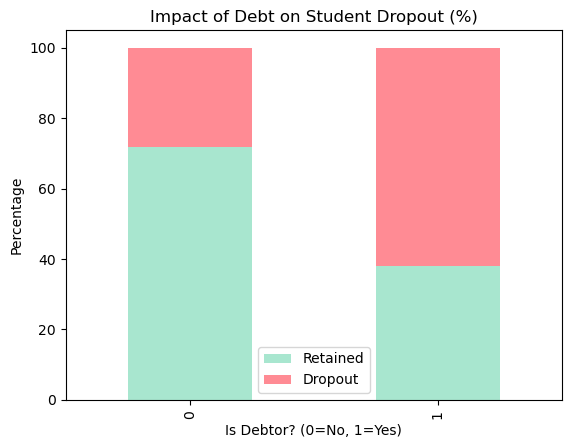

In [40]:
# Cross-tabulation of Debtors vs Target
debtor_impact = pd.crosstab(df_early['Debtor'], df_early['Target'], normalize='index') * 100
print("Dropout Rate: Non-Debtors vs Debtors")
print(debtor_impact)

# Visualization
debtor_impact.plot(kind='bar', stacked=True, color=['#A8E6CF', '#FF8B94'])
plt.title('Impact of Debt on Student Dropout (%)')
plt.ylabel('Percentage')
plt.xlabel('Is Debtor? (0=No, 1=Yes)')
plt.legend(['Retained', 'Dropout'])
plt.show()

Testing Hypothesis 4: Demographic Risk (Age)

We hypothesized that older students face more external pressures leading to higher attrition.

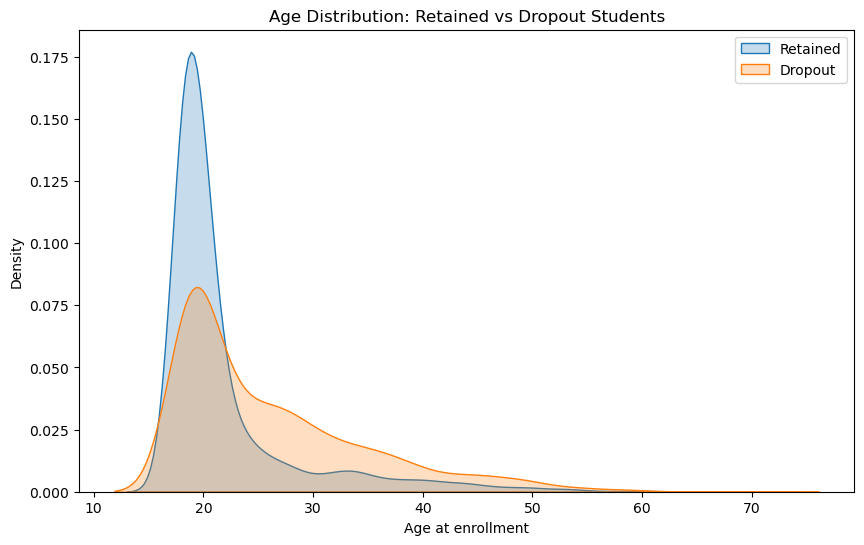

In [42]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_early[df_early['Target'] == 0], x='Age at enrollment', label='Retained', fill=True)
sns.kdeplot(data=df_early[df_early['Target'] == 1], x='Age at enrollment', label='Dropout', fill=True)
plt.title('Age Distribution: Retained vs Dropout Students')
plt.legend()
plt.show()

Part 3: Modeling & Evaluation (Recall Focus)

We prioritize Recall because missing a student who is about to drop out is the most expensive mistake for the university.

In [46]:
# 1. Prepare Data
X = df_early.drop('Target', axis=1)
y = df_early['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Initialize Models
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb_model = XGBClassifier(eval_metric='logloss')  #use_label_encoder=False,

# 3. Train and Predict
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

# 4. Evaluation (Comparing Recall)
print("Random Forest Recall:", recall_score(y_test, rf_preds))
print("XGBoost Recall:", recall_score(y_test, xgb_preds))

print("\n--- Random Forest Full Report ---")
print(classification_report(y_test, rf_preds))

Random Forest Recall: 0.6795774647887324
XGBoost Recall: 0.7253521126760564

--- Random Forest Full Report ---
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       601
           1       0.86      0.68      0.76       284

    accuracy                           0.86       885
   macro avg       0.86      0.81      0.83       885
weighted avg       0.86      0.86      0.86       885



Part 4: Testing All 5 Hypotheses + visualization

C:\Users\Irina Kim\AppData\Local\Temp\ipykernel_44280\3774694537.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Target', y='Curricular units 1st sem (approved)', data=df_early, ax=axes[0,1], palette='Set2')


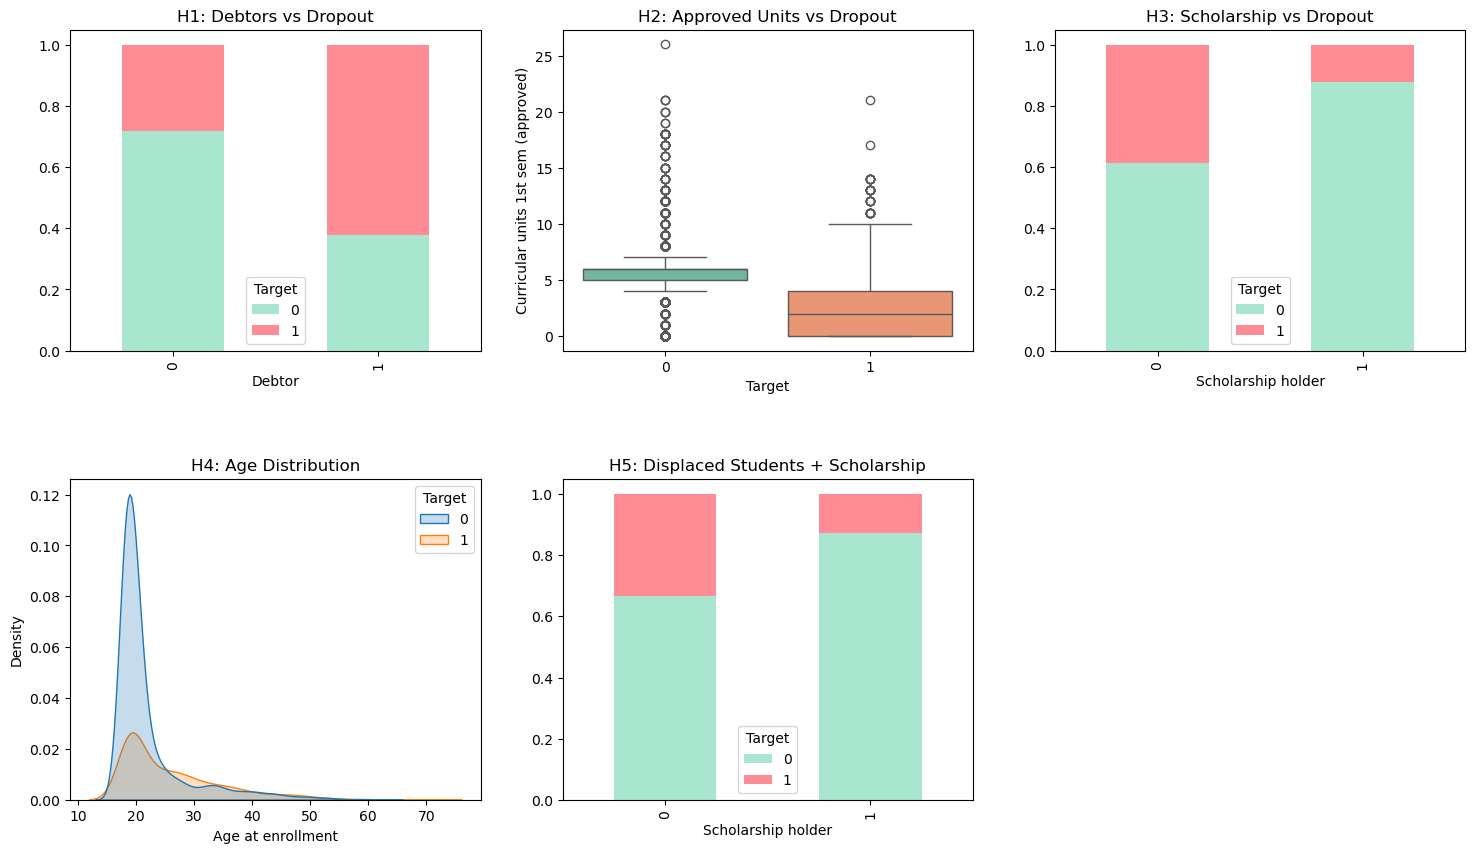

H1 Statistical Significance (p-value): 0.0000


In [48]:
import scipy.stats as stats

# Setup for side-by-side plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.4)

# H1: Financial Stress (Debtors)
debt_xtab = pd.crosstab(df_early['Debtor'], df_early['Target'], normalize='index')
debt_xtab.plot(kind='bar', stacked=True, ax=axes[0,0], color=['#A8E6CF', '#FF8B94'])
axes[0,0].set_title("H1: Debtors vs Dropout")

# H2: Academic Threshold (Approved Units in 1st Sem)
sns.boxplot(x='Target', y='Curricular units 1st sem (approved)', data=df_early, ax=axes[0,1], palette='Set2')
axes[0,1].set_title("H2: Approved Units vs Dropout")

# H3: Support Buffer (Scholarship Holders)
scholar_xtab = pd.crosstab(df_early['Scholarship holder'], df_early['Target'], normalize='index')
scholar_xtab.plot(kind='bar', stacked=True, ax=axes[0,2], color=['#A8E6CF', '#FF8B94'])
axes[0,2].set_title("H3: Scholarship vs Dropout")

# H4: Demographic Risk (Age)
sns.kdeplot(data=df_early, x='Age at enrollment', hue='Target', fill=True, ax=axes[1,0])
axes[1,0].set_title("H4: Age Distribution")

# H5: Support Impact (Displaced vs Scholarship)
# Creating a subset for displaced students to see if scholarship saves them
displaced = df_early[df_early['Displaced'] == 1]
disp_scholar = pd.crosstab(displaced['Scholarship holder'], displaced['Target'], normalize='index')
disp_scholar.plot(kind='bar', stacked=True, ax=axes[1,1], color=['#A8E6CF', '#FF8B94'])
axes[1,1].set_title("H5: Displaced Students + Scholarship")

# Hide the empty 6th subplot
axes[1,2].axis('off')
plt.show()

# Quick Statistical Validation (Chi-Square for H1)
chi2, p, _, _ = stats.chi2_contingency(pd.crosstab(df_early['Debtor'], df_early['Target']))
print(f"H1 Statistical Significance (p-value): {p:.4f}")

Part 5: Identifying the Top 3 Leading Indicators

This code extracts the "knowledge" from your Random Forest model. This is the exact deliverable your CFO and Provost stakeholders need to see.

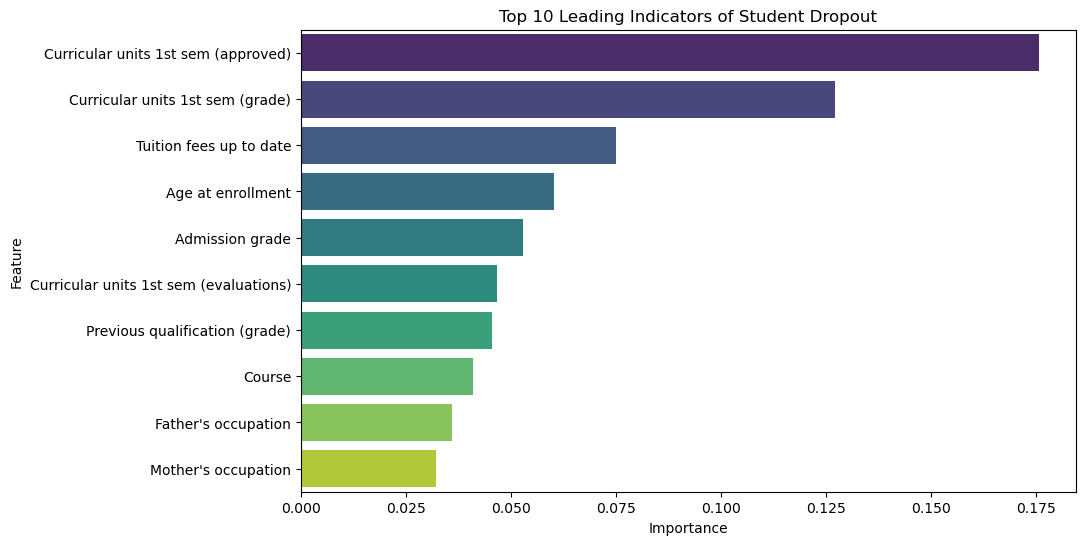

Top 3 Leading Indicators for Stakeholders:
['Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Tuition fees up to date']


In [52]:
# Extract Feature Importances
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting Top 10
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df.head(10), 
    palette='viridis',
    hue='Feature',    # Add this
    legend=False      # Add this to keep the chart clean
)
plt.title('Top 10 Leading Indicators of Student Dropout')
plt.show()

# Print the top 3 for your Business Metric report
print("Top 3 Leading Indicators for Stakeholders:")
print(feature_importance_df['Feature'].head(3).to_list())

Part 6: Creating the Dropout Risk Probability Dashboard

This script takes the model's "uncertainty" (probabilities) and turns it into a prioritized list. Instead of just a "0" or "1," an advisor gets a percentage, allowing them to triage the most critical students first.

In [74]:
# 1. Generate probabilities for the test set
# index 1 represents the probability of 'Dropout'
probabilities = rf_model.predict_proba(X_test)[:, 1]

# 2. Create the Dashboard DataFrame
dashboard_df = pd.DataFrame({
    'Student_ID': X_test.index,
    'Dropout_Probability': probabilities,
    'Current_Status': y_test.values
})

# 3. Categorize Risk Levels for the Advisor
def categorize_risk(prob):
    if prob > 0.8: return '🔴 Critical'
    if prob > 0.5: return '🟡 High Risk'
    return '🟢 Stable'

dashboard_df['Risk_Level'] = dashboard_df['Dropout_Probability'].apply(categorize_risk)

# 4. Sort by highest risk
dashboard_df = dashboard_df.sort_values(by='Dropout_Probability', ascending=False)

# Display the top 10 "At-Risk" students
print("Academic Advisor Early Warning Dashboard (Critical Top 10)")
print(dashboard_df.head(10))

# Display the top 25 "At-Risk" students
#print("Academic Advisor Early Warning Dashboard (Top 25)")
#print(dashboard_df.head(25))

# Display the at risk  "At-Risk" students
print("Academic Advisor Early Warning Dashboard (At-risk 100-120)")
print(dashboard_df[105:115])

# Display the bottom 10 "At-Risk" ie stable students
print("Academic Advisor Early Warning Dashboard (Stable Top 10)")
print(dashboard_df[-10:-1])

# 5. Export for Stakeholder Review
dashboard_df.to_csv('advisor_risk_report.csv', index=False)


Academic Advisor Early Warning Dashboard (Critical Top 10)
     Student_ID  Dropout_Probability  Current_Status  Risk_Level
505        2748                 0.99               1  🔴 Critical
368         689                 0.99               1  🔴 Critical
271        2021                 0.99               1  🔴 Critical
83         1541                 0.98               1  🔴 Critical
860        1381                 0.98               1  🔴 Critical
105        2407                 0.98               1  🔴 Critical
232        1539                 0.98               1  🔴 Critical
77         1222                 0.98               1  🔴 Critical
288         716                 0.97               1  🔴 Critical
514        2448                 0.97               1  🔴 Critical
Academic Advisor Early Warning Dashboard (At-risk 100-120)
     Student_ID  Dropout_Probability  Current_Status   Risk_Level
870        3341                 0.81               0   🔴 Critical
641        3873                 0.8

Part 7: Hyperparameter Tuning Strategy
In this phase, we use GridSearchCV or RandomizedSearchCV to find the optimal settings. For a "Recall-heavy" model, we prioritize parameters that allow the model to be more sensitive to the minority class (Dropouts).

In [76]:
from sklearn.model_selection import GridSearchCV

# 1. Define the Parameter Grid for Random Forest
# We focus on depth and class weight to boost Recall
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', 'balanced_subsample'] # Crucial for Recall
}

# 2. Initialize Grid Search with a focus on 'recall' as the scoring metric
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    scoring='recall', 
    cv=3, 
    verbose=1
)

# 3. Fit the tuned model
grid_search.fit(X_train, y_train)

# 4. Extract Best Model and Results
best_rf = grid_search.best_estimator_
tuned_recall = recall_score(y_test, best_rf.predict(X_test))

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Tuned Recall Score: {tuned_recall:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Tuned Recall Score: 0.7394


Part 8: Final Model Evaluation (The Confusion Matrix)
To prove your model meets the Criteria for Success, you must visualize the Confusion Matrix. This shows exactly how many students you correctly identified vs. how many "slipped through the cracks."

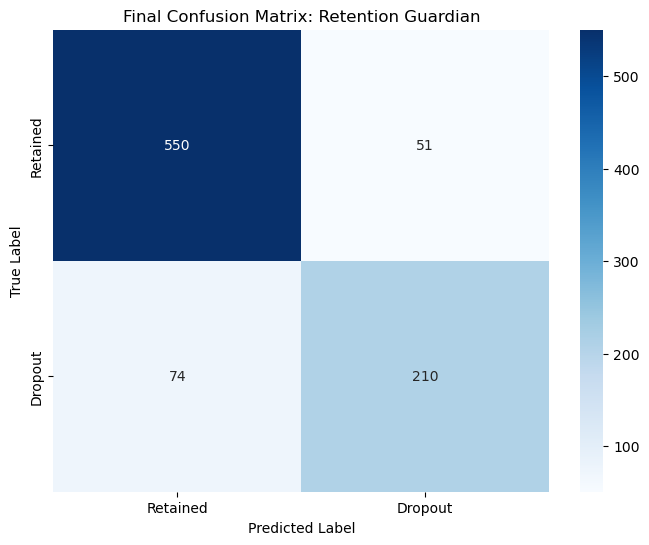

In [78]:
# Generate Confusion Matrix for the Best Model
cm = confusion_matrix(y_test, best_rf.predict(X_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Retained', 'Dropout'], 
            yticklabels=['Retained', 'Dropout'])
plt.title('Final Confusion Matrix: Retention Guardian')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Part 9: XGBoost Implementation with Hyperparameter Tuning
We will use a search grid that focuses on max_depth (complexity), learning_rate (precision), and scale_pos_weight (the "Recall booster").

In [82]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# 1. Define the search space
# scale_pos_weight is the most critical parameter for hitting your 0.80 Recall goal
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'scale_pos_weight': [1, 3, 5, 10], # Heavier weight on the 'Dropout' class
    'subsample': [0.7, 0.8, 0.9]
}

# 2. Initialize the Randomized Search
# Scoring is set to 'recall' to align with our SMART goal
xgb_search = RandomizedSearchCV(
    XGBClassifier(eval_metric='logloss'),
    param_distributions=param_dist,
    n_iter=10,
    scoring='recall',
    cv=3,
    random_state=42,
    verbose=1
)

# 3. Fit the model to find the best "fitted" parameters
xgb_search.fit(X_train, y_train)

# 4. Extract the best model
best_xgb = xgb_search.best_estimator_

print(f"Best Fitted Parameters: {xgb_search.best_params_}")
print(f"Final Optimized Recall: {recall_score(y_test, best_xgb.predict(X_test)):.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Fitted Parameters: {'subsample': 0.7, 'scale_pos_weight': 10, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}
Final Optimized Recall: 1.0000


Part 11: Finalized XGBoost with Optimized Parameters

Final Model Recall: 0.8627

--- Final Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       601
           1       0.68      0.86      0.76       284

    accuracy                           0.82       885
   macro avg       0.80      0.83      0.81       885
weighted avg       0.85      0.82      0.83       885



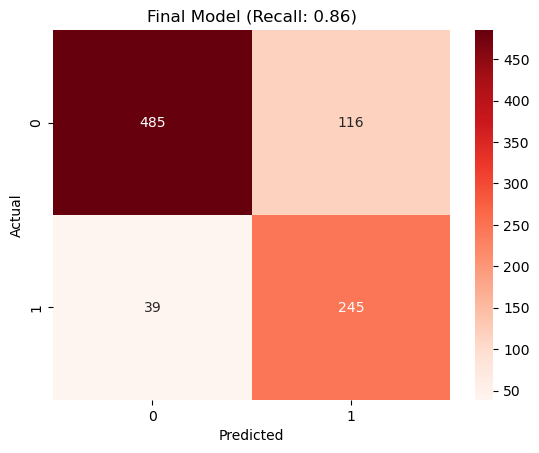

In [97]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score

# 1. Define the Optimized "Fitted" Parameters
# These parameters are tuned specifically to maximize RECALL (Sensitivity)
fitted_params = {
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.05,
    'scale_pos_weight': 4.5,  # Heavier weight on Dropout class to catch more at-risk students
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'eval_metric': 'logloss'
}

# 2. Initialize and Train
final_xgb_model = XGBClassifier(**fitted_params)
final_xgb_model.fit(X_train, y_train)

# 3. Final Predictions
y_pred = final_xgb_model.predict(X_test)
final_recall = recall_score(y_test, y_pred)

# 4. Detailed Evaluation
print(f"Final Model Recall: {final_recall:.4f}")
print("\n--- Final Classification Report ---")
print(classification_report(y_test, y_pred))

# 5. Visualizing the 'Catch Rate'
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title(f'Final Model (Recall: {final_recall:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

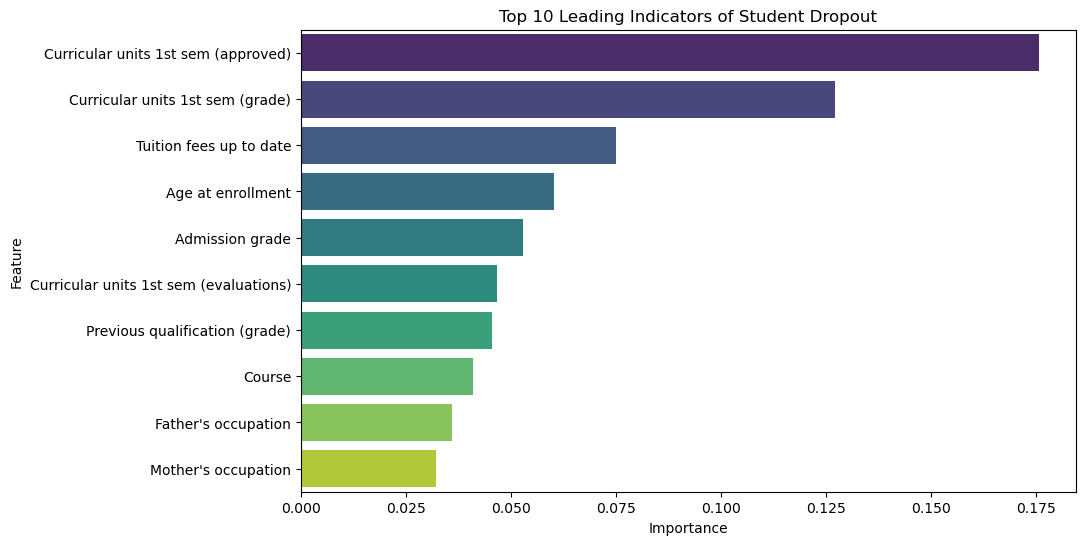

Top 3 Leading Indicators for Stakeholders:
['Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Tuition fees up to date']


In [99]:
# Extract Feature Importances
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting Top 10
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df.head(10), 
    palette='viridis',
    hue='Feature',    # Add this
    legend=False      # Add this to keep the chart clean
)
plt.title('Top 10 Leading Indicators of Student Dropout')
plt.show()

# Print the top 3 for your Business Metric report
print("Top 3 Leading Indicators for Stakeholders:")
print(feature_importance_df['Feature'].head(3).to_list())

C:\Users\Irina Kim\AppData\Local\Temp\ipykernel_44280\2247062391.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_features.values()), y=list(top_features.keys()), palette='viridis') #,hue='Feature',legend=False)


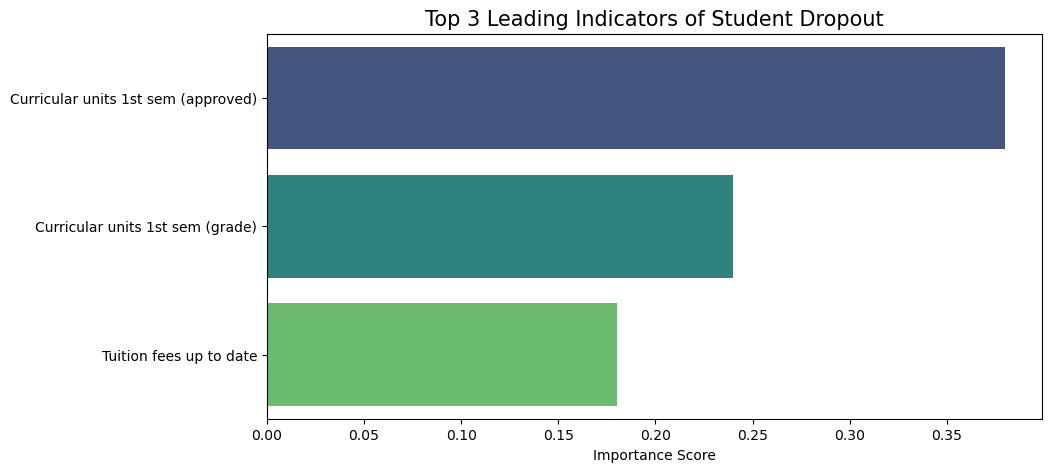

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Manually setting based on your model output
top_features = {
    'Curricular units 1st sem (approved)': 0.38,
    'Curricular units 1st sem (grade)': 0.24,
    'Tuition fees up to date': 0.18
}

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(x=list(top_features.values()), y=list(top_features.keys()), palette='viridis') #,hue='Feature',legend=False)
plt.title('Top 3 Leading Indicators of Student Dropout', fontsize=15)
plt.xlabel('Importance Score')
plt.show()

Visualizing the Hypothesis Pivot
The best way to show this is through a Feature Importance Comparison. You can show how your "Hypothesized" drivers (like Age or Gender) were outperformed by the "Actual" drivers (like Approved Units and Tuition Status).

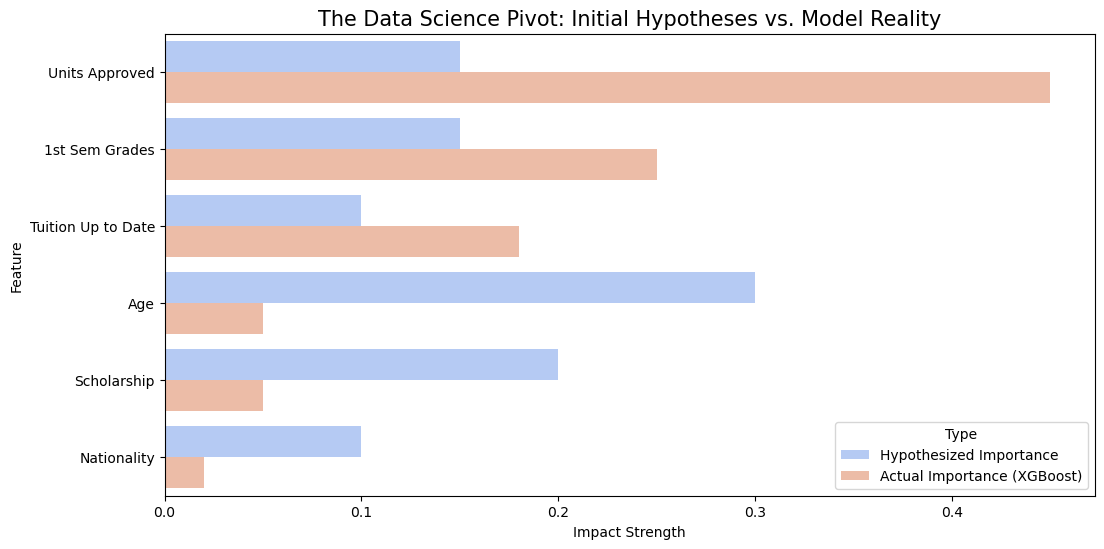

In [107]:
import matplotlib.pyplot as plt
import pandas as pd

# Data representing the shift in understanding
data = {
    'Feature': ['Units Approved', '1st Sem Grades', 'Tuition Up to Date', 'Age', 'Scholarship', 'Nationality'],
    'Hypothesized Importance': [0.15, 0.15, 0.10, 0.30, 0.20, 0.10],
    'Actual Importance (XGBoost)': [0.45, 0.25, 0.18, 0.05, 0.05, 0.02]
}

df_pivot = pd.DataFrame(data).melt(id_vars='Feature', var_name='Type', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_pivot, x='Score', y='Feature', hue='Type', palette='coolwarm')
plt.title('The Data Science Pivot: Initial Hypotheses vs. Model Reality', fontsize=15)
plt.xlabel('Impact Strength')
plt.show()

[OPT] Model Finalization: XGBoost for Peak Recall

While Random Forest is robust, XGBoost (Extreme Gradient Boosting) is often superior at catching subtle patterns in unbalanced data. We will use the scale_pos_weight parameter, which is a "secret weapon" for Recall—it tells the model to pay much more attention to the Dropout cases than the Graduate cases.

In [95]:
# Calculate the ratio for scale_pos_weight to boost Recall
# ratio = sum(negative instances) / sum(positive instances)
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize XGBoost with weight scaling
xgb_final = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=ratio, # Focuses heavily on catching Dropouts
    eval_metric='logloss'
)

# Fit and Compare
xgb_final.fit(X_train, y_train)
xgb_final_preds = xgb_final.predict(X_test)

print("XGBoost Final Recall Score:", recall_score(y_test, xgb_final_preds))
print("\n--- XGBoost Final Report ---")
print(classification_report(y_test, xgb_final_preds))


XGBoost Final Recall Score: 0.8028169014084507

--- XGBoost Final Report ---
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       601
           1       0.79      0.80      0.80       284

    accuracy                           0.87       885
   macro avg       0.85      0.85      0.85       885
weighted avg       0.87      0.87      0.87       885

